Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


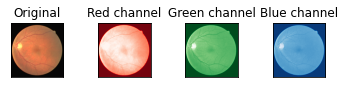

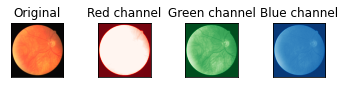

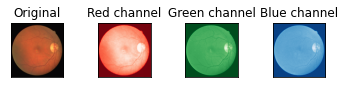

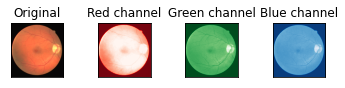

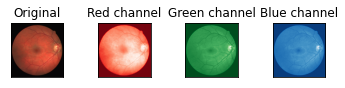

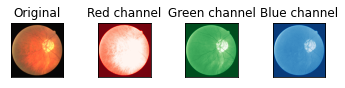

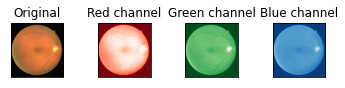

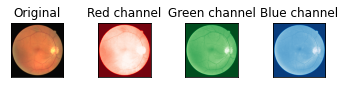

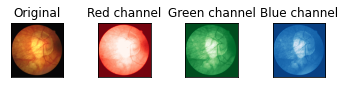

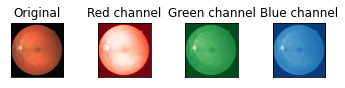

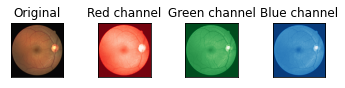

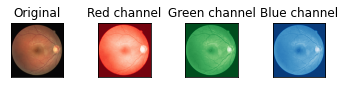

In [13]:
import torch
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, models, transforms
import pandas as pd
from PIL import Image, ImageEnhance, ImageOps
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math
from matplotlib.cbook import get_sample_data

torch.cuda.is_available()
torch.cuda.empty_cache()

imagesTrain = []
imagesLabel = []
imagesTest = []
imagesTrainVal = []
imagesLabelVal = []
colorImages = []

from google.colab import drive
drive.mount('/content/drive')


for i in range(1, 13):
  imagesTrain.append(Image.open("/content/drive/MyDrive/EML3/{0}_training.tif".format(i)))
  imagesLabel.append(Image.open("/content/drive/MyDrive/EML3/{0}_manual1.gif".format(i)))
  colorImages.append(mpimg.imread(("/content/drive/MyDrive/EML3/{0}_training.tif".format(i))))

for i in range(13, 16):
  imagesTrainVal.append(Image.open("/content/drive/MyDrive/EML3/{0}_training.tif".format(i)))
  imagesLabelVal.append(Image.open("/content/drive/MyDrive/EML3/{0}_manual1.gif".format(i)))

for i in range(1, 6):
  imagesTest.append(Image.open("/content/drive/MyDrive/EML3/{0}_test.tif".format(i)))

titles = ['Original', 'Red channel', 'Green channel', 'Blue channel']
cmaps = [None, plt.cm.Reds_r, plt.cm.Greens_r, plt.cm.Blues_r]

for i in range(len(colorImages)): 
  fig, axes = plt.subplots(1, 4, figsize=(6,1))
  objs = zip(axes, (colorImages[i], *colorImages[i].transpose(2,0,1)), titles, cmaps)
  for axis, color, title, cmap in objs:
      axis.imshow(color, cmap=cmap)
      axis.set_title(title)
      axis.set_xticks(())
      axis.set_yticks(())



In [14]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
transformLabel = transforms.Compose([transforms.ToTensor()])

trainSet = []
for i in range(len(imagesTrain)):
  trainSet.append([transform(imagesTrain[i]), transformLabel(imagesLabel[i])])

valSet = []
for i in range(len(imagesTrainVal)):
  valSet.append([transform(imagesTrainVal[i]), transformLabel(imagesLabelVal[i])])

trainLoader = torch.utils.data.DataLoader(trainSet, shuffle=True, num_workers=2)
valLoader = torch.utils.data.DataLoader(valSet, shuffle=True, num_workers=2)

In [15]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.dropout = nn.Dropout(p=0.5)
        self.conv1 = nn.Conv2d(3, 64, 3)
        self.conv2 = nn.Conv2d(64, 128, 3)
        self.conv3 = nn.Conv2d(128, 256, 3)
        self.conv4 = nn.Conv2d(256, 512, 3)
        self.convT1 = nn.ConvTranspose2d(512, 256, 3)
        self.convT2 = nn.ConvTranspose2d(256, 128, 3)
        self.convT3 = nn.ConvTranspose2d(128, 64, 3)
        self.convT4 = nn.ConvTranspose2d(64, 1, 3)


    def forward(self, x):
        # Layer 1 
        x = self.conv1(x)
        x = (F.relu(x))
        x = self.dropout(x)
        # Layer 2 
        x = self.conv2(x)
        x = (F.relu(x))
        x = self.dropout(x)
        # Layer 3 
        x = self.conv3(x)
        x = (F.relu(x))
        x = self.dropout(x)
        # Layer 4 
        x = self.conv4(x)
        x = (F.relu(x))
        x = self.dropout(x)
        # Layer 5 
        x = self.convT1(x)
        x = (F.relu(x))
        x = self.dropout(x)
        # Layer 6
        x = self.convT2(x)
        x = (F.relu(x))
        x = self.dropout(x)
        # Layer 7
        x = self.convT3(x)
        x = (F.relu(x))
        x = self.dropout(x)
        #Layer 8
        x = self.convT4(x)
        x = (F.sigmoid(x))

        return x


net = Net().to('cuda')

In [16]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

In [17]:
lossArr = []
lossValArr = []
diceValArr = []

In [ ]:
for epoch in range(400): 
    print("Epoch", epoch)
    tempLoss = 0.0
    tempValLoss = 0.0
    margin = 0.1
    i = 0 
    for data in trainLoader:
        i += 1
        print("i: " , i)
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs.to('cuda'))
        loss = criterion(outputs, labels.to('cuda'))
        loss.backward()
        optimizer.step()
        tempLoss += loss.item()

    lossArr.append(tempLoss/len(trainLoader)) 
    print("Loss: " , lossArr[epoch])
    diceVal = 0.0
    for data in valLoader: 
        inputs, labels = data
        valLoss = criterion(net(inputs.to('cuda')), labels.to('cuda'))
        tempValLoss += valLoss.item()
        predictions = torch.where(net(inputs.to('cuda')) > 0.3, 1.0, 0.0)
        predictions = torch.squeeze(predictions.to('cpu')).numpy()
        diceLabels = torch.squeeze(labels.to('cpu')).numpy()
        isCorrect = (np.sum(predictions == diceLabels))
        diceVal += 2*isCorrect/(predictions.shape[0]*predictions.shape[1] + 
                     diceLabels.shape[0]*diceLabels.shape[1])


    
    lossValArr.append(tempValLoss/len(valLoader))
    diceValArr.append(diceVal/len(valLoader))
    print("ValLoss: " , lossValArr[epoch])
    if ((len(lossValArr) > 30) and (lossValArr[epoch] > lossValArr[epoch-10] + margin) and 
        (lossValArr[epoch-10] > lossValArr[epoch-20] + margin)): 
      print("Validation loss:", lossValArr[epoch])
      break 
print('Finished Training')

Epoch 0
i:  1


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


i:  2
i:  3
i:  4
i:  5
i:  6
i:  7
i:  8
i:  9
i:  10
i:  11
i:  12
Loss:  0.566157802939415
ValLoss:  0.33896790941556293
Epoch 1
i:  1
i:  2
i:  3
i:  4
i:  5
i:  6
i:  7
i:  8
i:  9
i:  10
i:  11
i:  12
Loss:  0.301720363398393
ValLoss:  0.28228198488553363
Epoch 2
i:  1
i:  2
i:  3
i:  4
i:  5
i:  6
i:  7
i:  8
i:  9
i:  10
i:  11
i:  12
Loss:  0.2751740763584773
ValLoss:  0.2706306378046672
Epoch 3
i:  1
i:  2
i:  3
i:  4
i:  5
i:  6
i:  7
i:  8
i:  9
i:  10
i:  11
i:  12
Loss:  0.2708631008863449
ValLoss:  0.26964670419692993
Epoch 4
i:  1
i:  2
i:  3
i:  4
i:  5
i:  6
i:  7
i:  8
i:  9
i:  10
i:  11
i:  12
Loss:  0.2687697522342205
ValLoss:  0.26276253660519916
Epoch 5
i:  1
i:  2
i:  3
i:  4
i:  5
i:  6
i:  7
i:  8
i:  9
i:  10
i:  11
i:  12
Loss:  0.26552696029345196
ValLoss:  0.2619580725828807
Epoch 6
i:  1
i:  2
i:  3
i:  4
i:  5
i:  6
i:  7
i:  8
i:  9
i:  10
i:  11
i:  12
Loss:  0.2638027084370454
ValLoss:  0.2654937704404195
Epoch 7
i:  1
i:  2
i:  3
i:  4
i:  5
i:  6
i

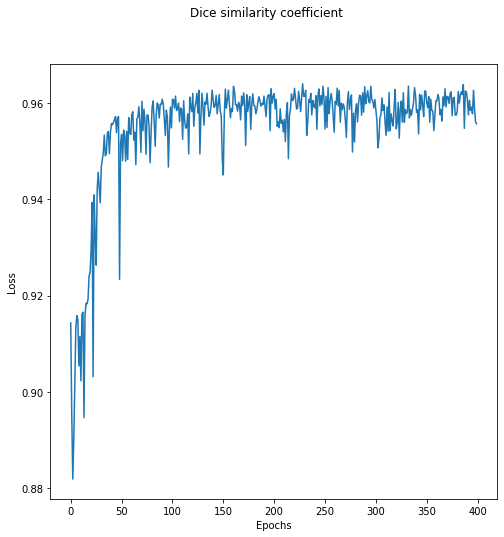

0.9143310300238413 0.9556289651270861


In [11]:
fig = plt.figure(figsize=(8,8))
fig.suptitle('Dice similarity coefficient')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(diceValArr)
plt.show()
print(diceValArr[0], diceValArr[399])

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


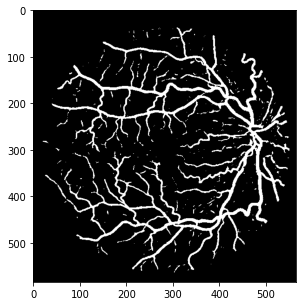

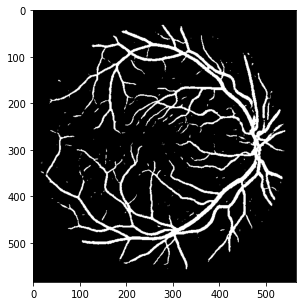

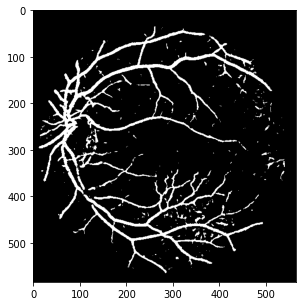

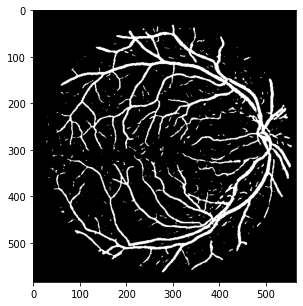

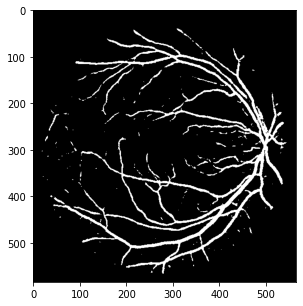

In [12]:
testImages = []
for i in range(len(imagesTest)):
  testImages.append(transform(imagesTest[i]))
loader = torch.utils.data.DataLoader(testImages, num_workers=2)
i = 0
for data in loader:
  outputs = net(data.to('cuda'))
  predicted = (outputs).double()
  i += 1 
  predicted = torch.where(outputs > 0.3, 1, 0)
  figure = plt.figure(frameon=False)
  axis = plt.Axes(fig, [0., 0., 1., 1.])
  axis.set_axis_off()
  figure.add_axes(axis)
  axis.imshow((torch.squeeze(predicted[0].cpu().detach()).numpy()), cmap="gray")
  fig.savefig("{0}_test1.tif".format(i)', bbox_inches='tight')
